In [25]:
import cv2
from PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import math
import gtsam
import gtsam.utils.plot as gtsam_plot

In [26]:
folder_dir = r"/home/nitin/EECE7150/HW 3/29images//"
Images = []
file_list = os.listdir(folder_dir)
sorted_file_list = sorted(
    file_list, key=lambda x: int(os.path.splitext(x)[0]) if x.isdigit() else x
)
for filename in sorted_file_list:
    gray_image = cv2.imread(folder_dir + filename, cv2.IMREAD_GRAYSCALE)
    normalImage = cv2.normalize(
        gray_image, None, 0, 255, cv2.NORM_MINMAX
    )  # normalisation of image
    Images.append(normalImage)

28


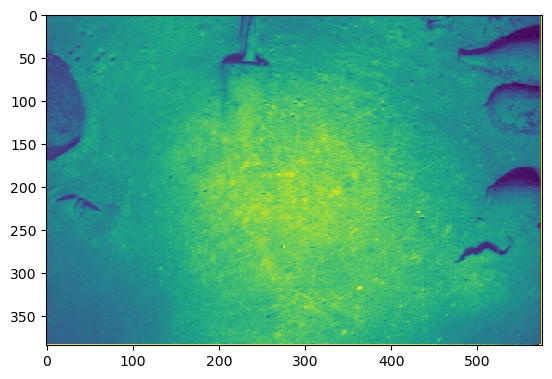

In [27]:
print(len(Images))
plt.imshow(Images[7])
plt.show()

In [28]:
def homographyFromDescriptors(
    dst_descriptor_1, src_descriptor_2, dst_keypoint_1, src_keypoint_2
):
    bf = cv2.BFMatcher()
    dst_descriptor_1 = np.array(dst_descriptor_1, dtype=np.float32)
    src_descriptor_2 = np.array(src_descriptor_2, dtype=np.float32)
    matches = bf.knnMatch(dst_descriptor_1, src_descriptor_2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.86 * n.distance:
            good_matches.append(m)

    dst_pts = np.float32([dst_keypoint_1[m.queryIdx].pt for m in good_matches])
    src_pts = np.float32([src_keypoint_2[m.trainIdx].pt for m in good_matches])

    homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1)
    return homography, good_matches

In [29]:
def masking(base_image, added_image):
    _, mask = cv2.threshold(base_image, 1, 255, cv2.THRESH_BINARY)
    inverted_mask = cv2.bitwise_not(mask)
    masked = cv2.bitwise_and(added_image, added_image, mask=inverted_mask)
    return masked

In [30]:
def NonMaxSuppressor(keypoint, descriptor, threshold):
    response = [kp.response for kp in keypoint]
    indices = np.argsort(response)[::-1]
    filtered = [keypoint[indices[0]]]
    filtered_descriptors = [descriptor[indices[0]]]
    for index in range(1, len(indices)):
        current_keypoint = keypoint[indices[index]]
        current_descriptor = descriptor[indices[index]]

        distance = np.linalg.norm(
            np.array(current_keypoint.pt) - np.array([kp.pt for kp in filtered]), axis=1
        )
        if np.all(distance > threshold):
            filtered.append(current_keypoint)
            filtered_descriptors.append(current_descriptor)
    return filtered, filtered_descriptors

In [31]:
sift = cv2.SIFT_create()
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
keypoints = []
descriptors = []
for iterator in range(len(Images)):
    clahe_image = clahe.apply(Images[iterator])
    keypoint, descriptor = sift.detectAndCompute(clahe_image, None)
    filter_keypoint, filter_descriptor = NonMaxSuppressor(keypoint, descriptor, 1)
    keypoints.append(filter_keypoint)
    descriptors.append(filter_descriptor)

In [32]:
# for cummulative homography ::

Hcummu_list = []
for iterator1 in range(len(Images)):
    H_intermediate_cummu = {"ImagesComp": [], "H_final": [], "goodmatch": []}
    for iterator2 in range(len(Images)):
        if iterator1 != iterator2:
            H_intermediate_cummu["ImagesComp"].append((iterator1 + 1, iterator2 + 1))
            homography, goodmatch = homographyFromDescriptors(
                descriptors[iterator1],
                descriptors[iterator2],
                keypoints[iterator1],
                keypoints[iterator2],
            )
            H_intermediate_cummu["H_final"].append(homography)
            H_intermediate_cummu["goodmatch"].append(len(goodmatch))

    Hcummu_list.append(H_intermediate_cummu)

In [33]:
# for gtsam::
H_list = []

for iterator1 in range(len(Images)):
    H_intermediate = {"ImagesComp": [], "H_final": [], "goodmatch": []}
    for iterator2 in range(len(Images)):
        if iterator1 != iterator2:
            H_intermediate["ImagesComp"].append((iterator1 + 1, iterator2 + 1))
            homography, goodmatch = homographyFromDescriptors(
                descriptors[iterator1],
                descriptors[iterator2],
                keypoints[iterator1],
                keypoints[iterator2],
            )
            H_intermediate["H_final"].append(homography)
            H_intermediate["goodmatch"].append(len(goodmatch))

    H_list.append(H_intermediate)

In [34]:
good_matches = []
for good in range(len(H_list)):
    good_matches.append(max(H_list[good]["goodmatch"]))
good_matches.sort()
print(good_matches)

[186, 215, 252, 259, 265, 343, 361, 363, 368, 370, 372, 377, 383, 392, 392, 395, 395, 400, 410, 415, 415, 419, 423, 451, 474, 479, 481, 484]


In [35]:
cummulative_H = [np.eye(3)]

compare_list = []
for i in range(len(Hcummu_list) - 1):
    compare_list.append(Hcummu_list[i]["ImagesComp"][i])
    H_Tra = np.dot(cummulative_H[-1], Hcummu_list[i]["H_final"][i])
    cummulative_H.append(H_Tra)

In [36]:
def extract_xy_theta_homography(Homograph):
    ## normalise homography first::
    Homograph_normalise = Homograph / Homograph[2, 2]
    R = Homograph_normalise[:2, :2]
    T = Homograph_normalise[:2, 2]
    # print(R)
    x_translation, y_translation = T
    theta = math.atan2(R[1, 0], R[0, 0])
    return x_translation, y_translation, theta

In [37]:
## given covariance function is taken reference from Lincoln Kinley ### where parameters and multipliers tuned by me ######


def covariance_calculator(matches, dx, dy, dth):
    ERF_DIV = 50
    LIN_DIV = 60

    covar_multiplier = 1 / math.erf((matches - 3) / ERF_DIV)

    exx = abs((dx * 8.5) / LIN_DIV) * covar_multiplier
    eyy = abs((dy * 0.75) / LIN_DIV) * covar_multiplier
    ett = abs((dth / 5) / (LIN_DIV)) * covar_multiplier

    return exx, eyy, ett

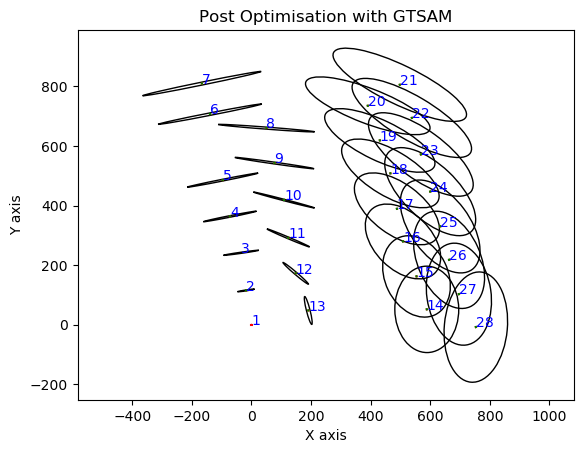

In [38]:
# GTSAM optimisation:
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(0.3, 0.3, 0.1))
graph = gtsam.NonlinearFactorGraph()
graph.add(gtsam.PriorFactorPose2(1, gtsam.Pose2(0, 0, 0), PRIOR_NOISE))


for listIterator in range(len(H_list)):
    for listIterator2 in range(len(H_list[listIterator]["H_final"])):
        match = H_list[listIterator]["goodmatch"][listIterator2]
        if (
            match > 165
        ):  # threshold set to reduce low matching error (reduce false loop closure)
            node1, node2 = H_list[listIterator]["ImagesComp"][listIterator2]
            x, y, theta = extract_xy_theta_homography(
                H_list[listIterator]["H_final"][listIterator2]
            )
            cx, cy, ct = covariance_calculator(match, x, y, theta)
            ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(cx, cy, ct))
            graph.add(
                gtsam.BetweenFactorPose2(
                    node1, node2, gtsam.Pose2(x, y, theta), ODOMETRY_NOISE
                )
            )

initial_estimate = gtsam.Values()
totalx, totaly, totalt = 0, 0, 0
for estimateIterator in range(len(cummulative_H)):
    x1, y1, theta1 = extract_xy_theta_homography(cummulative_H[estimateIterator])
    initial_estimate.insert(estimateIterator + 1, gtsam.Pose2(x1, y1, theta1))


parameters = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, parameters)
result = optimizer.optimize()

marginals = gtsam.Marginals(graph, result)
for i in range(1, len(Images) + 1):
    gtsam_plot.plot_pose2(0, result.atPose2(i), 0.5, marginals.marginalCovariance(i))
    plt.text(
        result.atPose2(i).x(), result.atPose2(i).y(), str(i), color="b", fontsize=10
    )

plt.title("Post Optimisation with GTSAM")
plt.axis("equal")
plt.show()

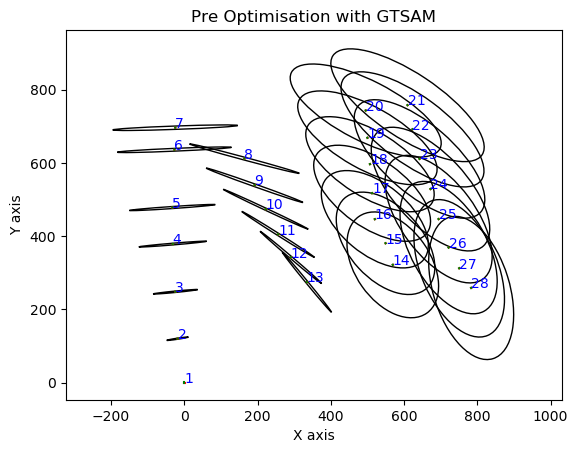

In [39]:
marginalinit = gtsam.Marginals(graph, initial_estimate)
for i in range(1, len(Images) + 1):
    gtsam_plot.plot_pose2(
        0, initial_estimate.atPose2(i), 0.5, marginalinit.marginalCovariance(i)
    )
    plt.text(
        initial_estimate.atPose2(i).x(),
        initial_estimate.atPose2(i).y(),
        str(i),
        color="b",
        fontsize=10,
    )

plt.title("Pre Optimisation with GTSAM")
plt.axis("equal")
plt.show()

In [40]:
Optimized_homography = []
for i in range(1, len(Images) + 1):  # Assuming you have 6 values
    pose_result = result.atPose2(i)
    x, y, theta = pose_result.x(), pose_result.y(), pose_result.theta()
    c, s = np.cos(theta), np.sin(theta)
    homography = np.array([[c, -s, x], [s, c, y], [0, 0, 1]])
    Optimized_homography.append(homography)

In [41]:
# Canvas creation for pre optimization:

# corner of images
transformed_corner = []
for index in range(len(Images)):
    height, width = Images[index].shape[:2]
    # Calculate the coordinates of the corners
    top_left = (0, 0)
    top_right = (width, 0)
    bottom_left = (0, height)
    bottom_right = (width, height)

    ImageCornerPoint = [top_left, bottom_left, bottom_right, top_right]
    imagecornernp = np.array([ImageCornerPoint], dtype=np.float32)
    transformedPoint = cv2.perspectiveTransform(imagecornernp, cummulative_H[index])
    transformed_corner.append(transformedPoint)

image_corner = []
for i in range(len(Images)):
    kpt = [kp.pt for kp in keypoints[i]]
    kpt_np = np.asarray(kpt).reshape(-1, 1, 2)
    transform_point = cv2.perspectiveTransform(kpt_np, cummulative_H[i])
    image_corner.append(transform_point)
all_points = np.concatenate(image_corner, axis=0)


min_x = np.min(all_points[:, :, 0])
min_y = np.min(all_points[:, :, 1])


translation_matrix = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])

updated_H = []
for i in range(len(Images)):
    updated_H_it = np.dot(translation_matrix, cummulative_H[i])
    updated_H.append(updated_H_it)

max_x = np.max(all_points[:, :, 0])
max_y = np.max(all_points[:, :, 1])
canvas_width = int((max_x - min_x))
canvas_height = int((max_y - min_y))

print("MIN X Pre optimization:", min_x)
print("MIN Y Pre optimization:", min_y)
print("MAX X Pre optimization:", max_x)
print("MAX Y Pre optimization:", max_y)
print("Canvas Width Pre optimization:", canvas_width)
print("Canvas Height Pre optimization:", canvas_height)

MIN X Pre optimization: -24.93880702575779
MIN Y Pre optimization: 2.375983715057373
MAX X Pre optimization: 901.2285179908704
MAX Y Pre optimization: 894.4001324539267
Canvas Width Pre optimization: 926
Canvas Height Pre optimization: 892


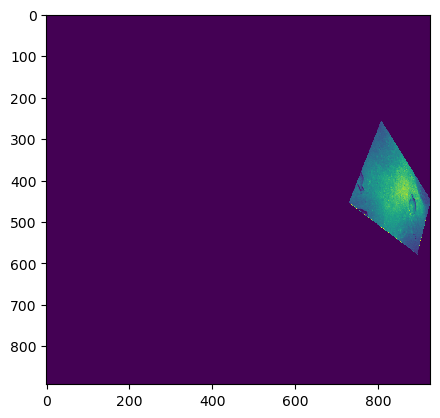

In [42]:
WarpedImage = []
for Idx in range(len(Images)):
    warped_image = cv2.warpPerspective(
        Images[Idx], updated_H[Idx], (canvas_width, canvas_height)
    )
    WarpedImage.append(warped_image)

plt.imshow(WarpedImage[-1])
plt.show()

In [43]:
Masked = [WarpedImage[0]]
for Jdx in range(1, len(Images) + 1):
    masked = masking(Masked[Jdx - 1], WarpedImage[Jdx - 1])
    blended = cv2.add(Masked[Jdx - 1], masked)
    Masked.append(blended)

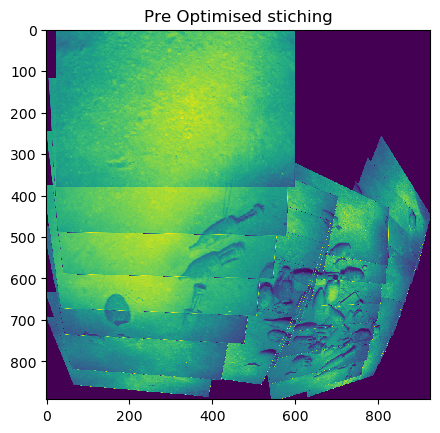

In [44]:
plt.title("Pre Optimised stiching")
plt.imshow(Masked[-1])
plt.show()

In [45]:
# Canvas creation for Post optimization:
# corner of images
transformed_corner = []
for index in range(len(Images)):
    height, width = Images[index].shape[:2]
    # Calculate the coordinates of the corners
    top_left = (0, 0)
    top_right = (width, 0)
    bottom_left = (0, height)
    bottom_right = (width, height)

    ImageCornerPoint = [top_left, bottom_left, bottom_right, top_right]
    imagecornernp = np.array([ImageCornerPoint], dtype=np.float32)
    transformedPoint = cv2.perspectiveTransform(
        imagecornernp, Optimized_homography[index]
    )
    transformed_corner.append(transformedPoint)

image_corner = []
for i in range(len(Images)):
    kpt = [kp.pt for kp in keypoints[i]]
    kpt_np = np.asarray(kpt).reshape(-1, 1, 2)
    transform_point = cv2.perspectiveTransform(kpt_np, Optimized_homography[i])
    image_corner.append(transform_point)
all_points = np.concatenate(image_corner, axis=0)

# Calculate the bounding box
min_x = np.min(all_points[:, :, 0])
min_y = np.min(all_points[:, :, 1])

# Calculate the translation matrix
translation_matrix = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])

# Apply the translation matrix to all other homography matrices
updated_H = []
for i in range(len(Images)):
    updated_H_it = np.dot(translation_matrix, Optimized_homography[i])
    updated_H.append(updated_H_it)

# Compute canvas dimensions after translation
max_x = np.max(all_points[:, :, 0])
max_y = np.max(all_points[:, :, 1])
canvas_width = int((max_x - min_x))
canvas_height = int((max_y - min_y))

# Print the canvas dimensions
print("MIN X:", min_x)
print("MIN Y:", min_y)
print("MAX X:", max_x)
print("MAX Y:", max_y)
print("Canvas Width:", canvas_width)
print("Canvas Height:", canvas_height)

MIN X: -162.1102756696049
MIN Y: -4.371578164646437
MAX X: 1295.827847064101
MAX Y: 1298.885853982728
Canvas Width: 1457
Canvas Height: 1303


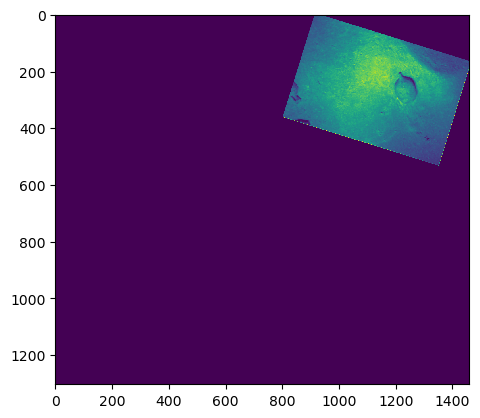

In [46]:
WarpedImage = []
for Idx in range(len(Images)):
    warped_image = cv2.warpPerspective(
        Images[Idx], updated_H[Idx], (canvas_width, canvas_height)
    )
    WarpedImage.append(warped_image)

plt.imshow(WarpedImage[27])
plt.show()

In [47]:
Masked = [WarpedImage[0]]
for Jdx in range(1, len(Images) + 1):
    masked = masking(Masked[Jdx - 1], WarpedImage[Jdx - 1])
    blended = cv2.add(Masked[Jdx - 1], masked)
    Masked.append(blended)

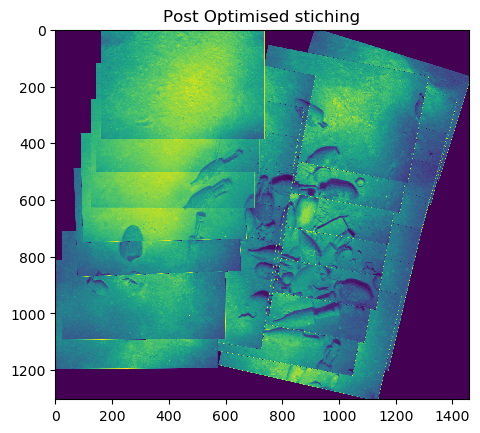

In [48]:
plt.title("Post Optimised stiching")
plt.imshow(Masked[-1])
plt.show()